### Import statments

In [2]:
import numpy
import re
import gensim
import numpy as np
from numpy.linalg import norm
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import urllib.request
import os

### Step 1: Load the Wikipedia GLoVE Word2Vec. Function to load GloVe into gensim format

In [4]:
def load_glove_model():
    """
    Download and load the GloVe model, if not already available.
    """
    # Check if the GloVe file or the zip exists
    glove_zip = 'glove.6B.zip'
    glove_file = 'glove.6B.300d.txt'
    word2vec_file = 'glove.6B.300d.word2vec'

    # Download the GloVe vectors if the zip and text files are not present
    if not os.path.exists(glove_file) and not os.path.exists(glove_zip):
        print("Downloading GloVe vectors...")
        url = 'http://nlp.stanford.edu/data/glove.6B.zip'
        urllib.request.urlretrieve(url, glove_zip)

    # Extract the GloVe zip if the text files are not yet available
    if not os.path.exists(glove_file):
        print("Extracting GloVe vectors...")
        import zipfile
        with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
            zip_ref.extractall()

    # Convert GloVe to Word2Vec format if not already converted
    if not os.path.exists(word2vec_file):
        print("Converting GloVe to Word2Vec format...")
        glove2word2vec(glove_file, word2vec_file)

    # Load the Word2Vec model
    print("Loading the GloVe model...")
    model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)
    
    return model

# Load the model
print("Loading model...")
model = load_glove_model()
print("Model loaded successfully!")


Loading model...
Loading the GloVe model...
Model loaded successfully!


### Step 2: Show how similar are these words:Cosine similarity function. 

In [6]:
def calculate_similarities(model, word_pairs):
    """
    Calculate similarities between pairs of words
    """
    similarities = {}
    for word1, word2 in word_pairs:
        try:
            similarity = model.similarity(word1.lower(), word2.lower())
            similarities[(word1, word2)] = similarity
        except KeyError:
            similarities[(word1, word2)] = "One or both words not in vocabulary"
    return similarities

# Calculate similarities
word_pairs = [
    ('man', 'woman'),
    ('chair', 'throne'),
    ('water', 'baby')
]
    
print("\nWord Similarities:")
similarities = calculate_similarities(model, word_pairs)
for (word1, word2), similarity in similarities.items():
    print(f"{word1} - {word2}: {similarity:.4f}")


Word Similarities:
man - woman: 0.6999
chair - throne: 0.2755
water - baby: 0.2417


### Step 3: Using these provide analogies for the following:

In [8]:
# Step 3: Find analogies
def find_analogies(model, analogies):
    """
    Find analogies using word vectors
    """
    results = {}
    for analogy in analogies:
        try:
            result = model.most_similar(
                positive=[analogy[1], analogy[2]], 
                negative=[analogy[3]]
            )[0][0]
            results[tuple(analogy)] = result
        except KeyError:
            results[tuple(analogy)] = "One or more words not in vocabulary"
    return results
# Find analogies
analogies = [
    ['queen', 'king', 'woman', 'man'],      # Queen is to King as Woman is to Man
    ['prince', 'princess', 'man', 'woman'], # Prince is to Princess as Man is to Woman
    ['girl', 'woman', 'child', 'adult']     # Girl is to Woman as Child is to Adult]
]
print("\nAnalogies:")
results = find_analogies(model, analogies)
for analogy, result in results.items():
    print(f"{analogy[0]} is to {analogy[1]} as {analogy[2]} is to {analogy[3]}")
    print(f"Result: {result}")


Analogies:
queen is to king as woman is to man
Result: queen
prince is to princess as man is to woman
Result: prince
girl is to woman as child is to adult
Result: mother


### Step 4: Apply Naive-Bayes Classifier on the Spam-Ham dataset shown in the demo.

In [29]:
from sklearn_pandas import DataFrameMapper
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
import scikitplot as skplt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
#from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monicalokare/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Creating emoticon list

In [32]:
emotions_list = [":)", ":(", ":p", ":D", "-_-", ":o"]

### Filtering SMS based on character length

In [35]:
def char_flag(l):
    if l <= 40:
        return 1
    elif l <= 60:
        return 2
    elif l <= 80:
        return 3
    elif l <= 120:
        return 4
    elif l <= 160:
        return 5
    else:
        return 6 

### Removing stopwords

In [38]:
stop_words = []
def text_process(mess):
    no_punct = re.sub('[^A-Za-z ]+', '', mess.lower())
    return np.array([stemmer.stem(word) for word in no_punct.split() if word not in stop_words])

### Data Preprocessing

In [43]:
def preprocessing_text():
    for d, ln in zip(messages_data, token_4):
        token_1.append(d)
        token_2.append(d.count('$'))
        
        # Extract numeric values from the message
        x = re.sub('[^0-9 ]+', '', d.lower())
        token_3.append(len(x))
        
        # Custom flag based on message length
        token_5.append(char_flag(ln))
        
        # Check for URL-like patterns in the message
        if re.sub(r'[^://@]', '', d.lower()) != '':
            token_6.append(1)
        else:
            token_6.append(0)
        
        # Number of words in the numeric part
        token_7.append(len(x.split()))
        
        # Check for the presence of specific emojis
        for emoji in emotions_list:
            if re.search(re.escape(emoji), d):
                token_8.append(1)
            else:
                token_8.append(0)

    # Return the tokenized data as a NumPy array
    return np.array([
        np.array([token_1[i], token_2[i], token_3[i], token_4[i], token_5[i], 
                  token_6[i], token_7[i], token_8[i]], dtype=object) 
        for i in range(len(messages_data))
    ])


### Data conversion to vector form

In [46]:
def data_mapper():
    data = preprocessing_text()
    labels = ['message','f1','f2','f3','f4','f5','f6','f7']
    df = pd.DataFrame.from_records(data,columns=labels)
    mapper = DataFrameMapper([
    (['f1', 'f2','f3','f4','f5','f6','f7'], None),
    ('message',CountVectorizer(analyzer = text_process,ngram_range=(2, 2)))])
    X=mapper.fit_transform(df)
    return X

### Step 4: Load dataset and preprocess

In [49]:
if __name__ == "__main__":
   
    messages = pd.read_csv("spam.csv", encoding='latin-1')
    print(messages)
    messages = messages.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
    print(messages)
    

        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  


In [51]:
    messages['length'] = messages['v2'].apply(len)
    messages_data = messages['v2']
    messages_labels = messages['v1']
    print(messages)

        v1                                                 v2  length
0      ham  Go until jurong point, crazy.. Available only ...     111
1      ham                      Ok lar... Joking wif u oni...      29
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3      ham  U dun say so early hor... U c already then say...      49
4      ham  Nah I don't think he goes to usf, he lives aro...      61
...    ...                                                ...     ...
5567  spam  This is the 2nd time we have tried 2 contact u...     161
5568   ham              Will Ì_ b going to esplanade fr home?      37
5569   ham  Pity, * was in mood for that. So...any other s...      57
5570   ham  The guy did some bitching but I acted like i'd...     125
5571   ham                         Rofl. Its true to its name      26

[5572 rows x 3 columns]


In [59]:
    token_1 = []
    token_2 = []
    token_3 = []
    token_4 = messages['length']
    token_5 = []
    token_6 = []
    token_7 = []
    token_8 = []
    
    freq = pd.Series(' '.join(messages_data).split()).value_counts()
    print(freq)

to           2134
you          1622
I            1466
a            1327
the          1197
             ... 
AOM             1
Box61,M60       1
1ER             1
Ages            1
Rofl.           1
Length: 15585, dtype: int64


In [61]:
    stop_words = stopwords.words('english')
    print(stop_words)
    stop_words.extend(freq[-9268:].index)
    print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [64]:
    mapped_data = data_mapper()

    trainset, testset, trainlabel, testlabel = train_test_split(mapped_data, messages_labels, test_size=0.33, random_state=42)  

/Users/monicalokare/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Accuracy (Naive Bayes): 0.9842
Confusion Matrix (Naive Bayes): [[1577   10]
 [  19  233]]


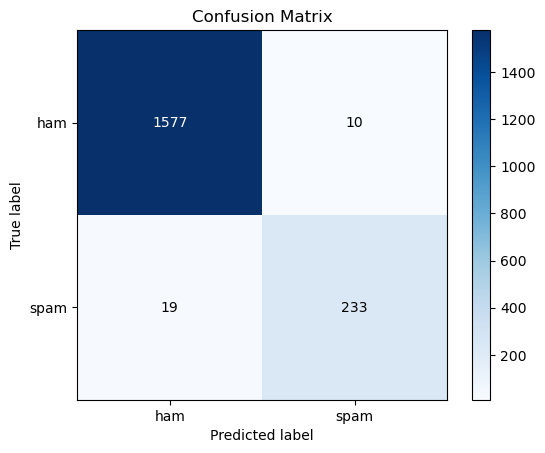

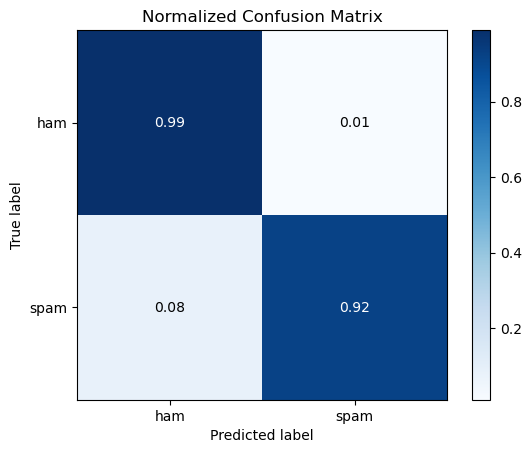

Cross Validation Scores: [0.98393574 0.9772423  0.98393574 0.98659517 0.97989276]


In [68]:

    # Step 6: Train Naive Bayes Classifier
    nb = MultinomialNB()
    nb.fit(trainset, trainlabel)

    # Step 7: Make predictions
    predicted_values_nb = nb.predict(testset)

    # Step 8: Evaluate the model
    accuracy_nb = accuracy_score(testlabel, predicted_values_nb)
    print(f"Accuracy (Naive Bayes): {accuracy_nb:.4f}")

    # 5-Fold Cross Validation
    scores = cross_val_score(nb, trainset, trainlabel, cv=5)

    # Confusion Matrix
    confusion_matrix_nb = confusion_matrix(testlabel, predicted_values_nb, labels=["ham", "spam"])
    skplt.metrics.plot_confusion_matrix(testlabel, predicted_values_nb, normalize=False)
    skplt.metrics.plot_confusion_matrix(testlabel, predicted_values_nb, normalize=True)
    
    print('Confusion Matrix (Naive Bayes):', confusion_matrix_nb)
    plt.show()

    # Display validation scores
    print("Cross Validation Scores:", scores)


### Results and Analysis
- Accuracy and Model Performance: The accuracy of the Naive Bayes model is 98.42%, indicating that the model correctly predicted most messages in the dataset as either spam or ham.
- Cross-validation scores across 5 folds were:[0.9839, 0.9772, 0.9839, 0.9866, 0.9799],demonstrating consistent performance with only minor variations. This consistency across folds reflects that the model generalizes well to unseen data and is not overfitting.
### Confusion Matrix Analysis:
    - True Positives (TP): 233 spam messages correctly identified as spam.
    - True Negatives (TN): 1577 ham messages correctly identified as ham.
    - False Positives (FP): 10 ham messages incorrectly classified as spam.
    - False Negatives (FN): 19 spam messages incorrectly classified as ham.
99% of actual ham messages were correctly identified.
92% of spam messages were correctly classified, with 8% missed and predicted as ham.
### Insights
- High accuracy and high precision/recall suggest that the Naive Bayes model is effective in identifying spam messages.
- False Positives (FP) are relatively low (10 out of 1587 ham messages), meaning the model rarely misclassifies ham messages as spam.
- False Negatives (FN) are also minimal (19 out of 252 spam messages), indicating the model captures most spam, but a small percentage slips through undetected.